# Vector Tensor Property Prediction

This notebook demonstrates how to use a trained GRACE model to predict a vector tensor property. We will:

1. Load the model as an ASE calculator with the extra property enabled
2. Read a test dataset and make predictions for the tensor property
3. Compute error metrics (MAE, RMSE) between predictions and true values
4. Verify rotational equivariance by rotating a structure and comparing tensors

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
from tensorpotential.calculator import TPCalculator

[tensorpotential] Info: Environment variable TF_USE_LEGACY_KERAS is automatically set to '1'.


2026-02-26 23:12:45.704230: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-26 23:12:46.041309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772143966.123619 3822025 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772143966.135917 3822025 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772143966.201798 3822025 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Load GRACE Calculator

We create an ASE calculator from the trained model, enabling the additional tensor property prediction. The `truncate_extras_by_natoms` flag ensures the property tensor is sized according to system size.

In [4]:
calc = TPCalculator('seed/1/final_model',
                     extra_properties=['predict_tensor'],
                     truncate_extras_by_natoms=True
                     )

2026-02-26 23:13:00.235699: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1772143980.238892 3822025 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4479 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:b3:00.0, compute capability: 8.6


## Load Test Dataset

We read the test set (pickled) which contains the true tensor properties. The data frame will be iterated to compute predictions.

In [5]:
df=pd.read_pickle("seed/1/test_set.pkl.gz")

In [6]:
df

,ase_atoms,energy,forces,tensor_property,name,NUMBER_OF_ATOMS
80,"(Atom('H', [5.62344, 7.04856, 3.37968], index=...",-938.535945,"[[-0.130735, -0.627636, 0.141614], [-0.148006,...","[[-0.130735, -0.627636, 0.141614], [-0.148006,...",H2O_100.pkl.gz:80,192
84,"(Atom('H', [5.32664, 6.74621, 3.58678], index=...",-938.827010,"[[0.0052, 0.357107, 0.008451], [-0.039093, -0....","[[0.0052, 0.357107, 0.008451], [-0.039093, -0....",H2O_100.pkl.gz:84,192
33,"(Atom('H', [5.9337, 6.78704, 4.0118], index=0)...",-938.270664,"[[0.434534, -0.692188, -0.032982], [0.710522, ...","[[0.434534, -0.692188, -0.032982], [0.710522, ...",H2O_100.pkl.gz:33,192
81,"(Atom('H', [6.26778, 6.63521, 3.648], index=0)...",-938.096462,"[[0.663717, -1.043306, -0.23846], [-0.13751, 0...","[[0.663717, -1.043306, -0.23846], [-0.13751, 0...",H2O_100.pkl.gz:81,192
93,"(Atom('H', [5.19152, 6.70907, 3.39694], index=...",-939.239965,"[[0.146152, 2.088429, 1.06103], [-0.035848, -0...","[[0.146152, 2.088429, 1.06103], [-0.035848, -0...",H2O_100.pkl.gz:93,192


## Prediction and Error Metrics

After computing the predicted tensor for each structure, we calculate the mean absolute error (MAE) and root mean squared error (RMSE) between the flattened true and predicted tensors.

In [7]:
t_pred_list=[]

for _, row in df.iterrows():
    at=row['ase_atoms']    
    at.calc=calc
    at.get_potential_energy()    
    t_pred=at.calc.results['predict_tensor']
    t_pred_list.append(t_pred) 

I0000 00:00:1772143980.849715 3822025 service.cc:152] XLA service 0x5560e1e95540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772143980.849737 3822025 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2026-02-26 23:13:00.917483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1772143981.083124 3822025 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1772143982.706178 3822025 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
df['tensor_property_predicted']=t_pred_list

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# flatten all tensors into one long vector per entry
true_flat = np.vstack(df['tensor_property']).flatten()
pred_flat = np.vstack(df['tensor_property_predicted']).flatten()

mae = mean_absolute_error(true_flat, pred_flat)
rmse = np.sqrt(mean_squared_error(true_flat, pred_flat))
print(f"MAE = {mae:.6e}, RMSE = {rmse:.6e}")


MAE = 4.272509e-02, RMSE = 5.557389e-02


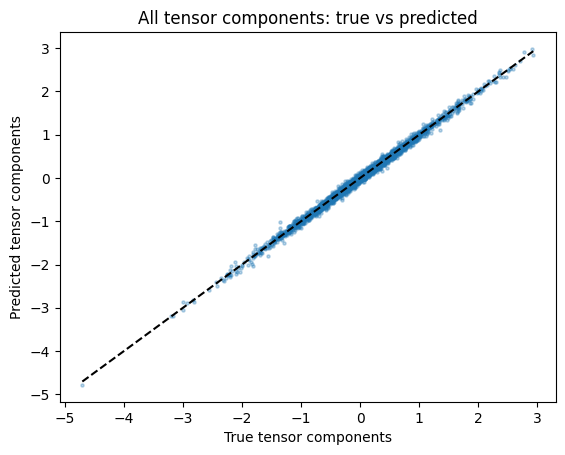

In [12]:
# scatter plot for entire dataset using flattened values
plt.scatter(true_flat, pred_flat, alpha=0.3, s=5)
plt.xlabel('True tensor components')
plt.ylabel('Predicted tensor components')
plt.title('All tensor components: true vs predicted')
plt.plot([true_flat.min(), true_flat.max()], [true_flat.min(), true_flat.max()], 'k--')

## Rotational Equivariance Test

To verify the model's tensor prediction is rotationally equivariant, we pick a structure, apply a random rotation to its atomic positions and true tensor, then recompute the prediction and compare with the rotated true value.

In [18]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# 1. Get the unrotated structure
row = df.iloc[0]
atoms_unrotated = row['ase_atoms'].copy()

# 2. Get model prediction on the UNROTATED structure
atoms_unrotated.calc = calc
atoms_unrotated.get_potential_energy()
pred_unrotated = atoms_unrotated.calc.results['predict_tensor']

# 3. Generate random rotation matrix
rot = R.random().as_matrix()

# 4. Create a rotated copy of the structure
atoms_rotated = atoms_unrotated.copy()
pos = atoms_rotated.get_positions()
atoms_rotated.set_positions(pos.dot(rot.T))
if atoms_rotated.cell is not None:
    atoms_rotated.set_cell(np.dot(atoms_rotated.cell, rot.T), scale_atoms=False)

# 5. Get model prediction on the ROTATED structure
atoms_rotated.calc = calc
atoms_rotated.get_potential_energy()
pred_rotated = atoms_rotated.calc.results['predict_tensor']

# 6. Rotate the unrotated prediction
rotated_pred_unrotated = pred_unrotated.dot(rot.T)

# 7. Compare the two predictions
print("Equivariance diff norm:", np.linalg.norm(pred_rotated - rotated_pred_unrotated))

Equivariance diff norm: 7.811998652373096e-09


### Interpretation

A small difference norm (close to zero) indicates the model respects rotational equivariance: rotating the structure rotates the predicted vector in the same way.
